# Best practices in Google Colab for sharing with non-technical teams

In teams where technical and non-technical profiles coexist, it
is common for the technical team to develop notebooks in Google
Colab for periodic processes: monthly reports, data analysis,
recurring tasks. The problem arises when these processes require
periodic execution with small variations — a different month,
another department, a new input file — and the responsibility
of running them always falls on the technical team.

This dynamic creates unnecessary overhead: the technical team
becomes a bottleneck for tasks that, with the right structure,
anyone could run autonomously.

The solution is to structure notebooks so that non-technical
teams can execute them on their own, without risk of altering
the logic and without needing to understand the code. This
notebook presents the best practices I have applied in my
experience and also serves as a downloadable template you can
adapt to your own processes.

## Recommended structure

The structure that has worked best for me organizes the notebook
into five well-defined blocks:

1. **Documentation**: Markdown cells explaining what the process
   does, what data it needs, what results it produces and how to
   use it.
2. **Imports and Drive initialization**: First code cell, always
   visible. Requests Google Drive permissions as early as
   possible so the user grants access immediately and the rest
   runs uninterrupted.
3. **Editable parameters**: Visible code cell with Colab form
   fields. The only values the non-technical team should modify.
4. **Technical variables and processing logic**: Hidden code
   cells to avoid confusion. Contain internal configurations
   and functions.
5. **Main execution**: Visible code cell that runs the full
   process and displays progress messages and results.

## Process documentation

Every shared notebook must start with clear documentation. It is
the first impression the user gets and determines whether they
can use it without help. The documentation should include: what
the process does, what input data it needs (files and location),
what output data it generates (files and location) and step-by-step
instructions for running it.

Below is an example of documentation for a report generation
process.

> **Process**: Monthly departmental report.
>
> **Objective**: Generate a monthly summary from daily operations
> data for a department.
>
> **Input data**: CSV file in `My Drive/reports/data/` named
> `data_YYYY_MM.csv` (e.g., `data_2026_02.csv`).
>
> **Output data**: CSV report in `My Drive/reports/results/`
> named `report_DEPARTMENT_YYYY_MM.csv` (e.g.,
> `report_sales_2026_02.csv`).
>
> **Instructions**:
> 1. Run the first code cell and authorize Google Drive access.
> 2. Modify the parameters (year, month and department) in the
>    **Parameters** cell.
> 3. From the menu, select *Runtime* > *Run all* (or
>    `Ctrl+F9`).
> 4. Wait for completion. Progress will be shown in the last
>    cell.

## Imports and Drive initialization

This block is placed as the first code cell for two reasons:

1. Google Drive requires user authorization. If this cell comes
   first, the user grants permission immediately and the rest of
   the notebook runs without interruptions.
2. Early error detection: if there is a problem with the Drive
   connection or any dependency, it is caught before executing
   any logic.

In [ ]:
# @title Default title text
import pandas as pd
from datetime import datetime
from pathlib import Path

from google.colab import drive

drive.mount("/content/drive")
print("Drive connected successfully.")

Mounted at /content/drive
Drive connected successfully.


## Parameters (non-technical team)

This is the only cell the non-technical team should modify.
Parameters are presented as Colab form fields using the
`#@param` syntax, which generates visual controls (text fields,
dropdowns, etc.) that make editing easy without touching code.

An important tip: use closed lists
(`#@param ["option1", ...]`) instead of free text whenever
possible. This prevents typos and ensures valid values.
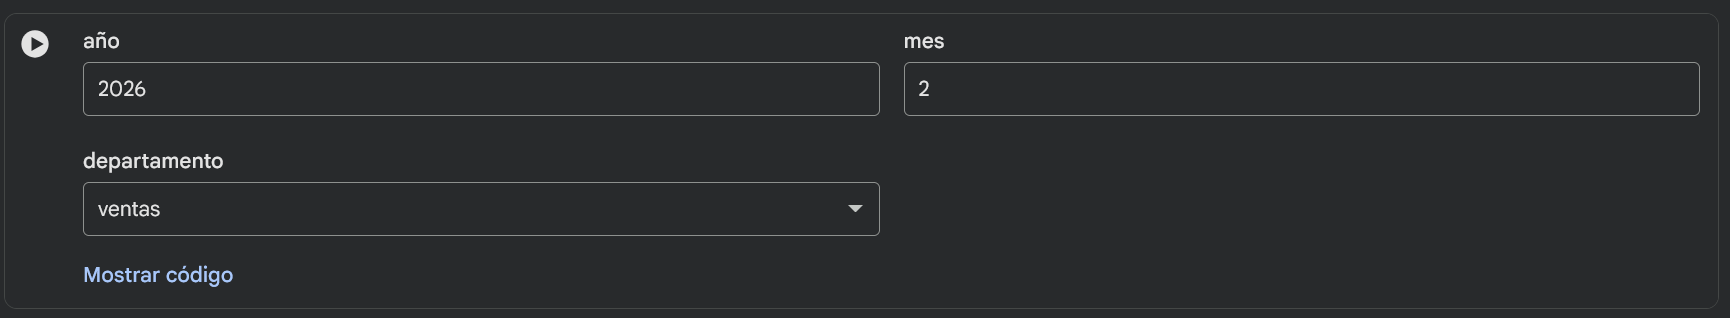

In [ ]:
#@title Report parameters
year = 2026 #@param {type:"integer"}
month = 2 #@param {type:"integer"}
department = "sales" #@param ["sales", "marketing", "operations"]

## Technical variables (technical team)

The following cells contain internal configurations that the
non-technical team does not need to see or modify. In Google
Colab, cells are hidden using `#@title` as the first line and
setting the cell view to form (*cellView: form*). This
collapses them visually, showing only the title.

To configure this:

- Add `#@title Descriptive title` as the first line of the
  code cell.
- Click the three dots on the cell > *Form view*.
- Or set `"cellView": "form"` in the cell metadata.

In [ ]:
#@title Technical variables (do not modify)
BASE_DIR = Path("/content/drive/MyDrive/reports")
INPUT_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "results"

INPUT_FILE = INPUT_DIR / f"data_{year}_{month:02d}.csv"
OUTPUT_FILE = OUTPUT_DIR / f"report_{department}_{year}_{month:02d}.csv"

REQUIRED_COLUMNS = ["date", "department", "category", "amount"]

## Processing logic (technical team)

The processing logic is also hidden. All functionality is
encapsulated in functions with descriptive names. This makes
maintenance easier for the technical team and prevents the
non-technical team from accidentally modifying the logic.

In [ ]:
#@title Processing functions (do not modify)

def validate_params(year, month, department):
    """Validates that parameters are correct."""
    errors = []
    if not (2020 <= year <= 2030):
        errors.append(f"Year out of range: {year}")
    if not (1 <= month <= 12):
        errors.append(f"Invalid month: {month}")
    if department not in ["sales", "marketing", "operations"]:
        errors.append(f"Unrecognized department: {department}")
    return errors


def load_data(path):
    """Loads the CSV file and validates columns."""
    if not path.exists():
        raise FileNotFoundError(
            f"File not found: {path}\n"
            f"Please verify the file exists in Google Drive."
        )
    df = pd.read_csv(path)
    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in file: {missing}")
    return df


def process_data(df, department):
    """Filters and aggregates data by department."""
    df_filtered = df[df["department"] == department].copy()
    if df_filtered.empty:
        raise ValueError(
            f"No data found for department: {department}"
        )
    summary = (
        df_filtered
        .groupby("category")
        .agg(
            total=("amount", "sum"),
            count=("amount", "count"),
            average=("amount", "mean"),
        )
        .reset_index()
        .sort_values("total", ascending=False)
    )
    return summary


def save_report(df, path):
    """Saves the report to the specified path."""
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)

## Execution

This cell runs the full process. It remains visible so the
non-technical team can verify progress and results. Log messages
indicate each step.

In [ ]:
print(f"{'=' * 50}")
print(f"Report: {department} - {year}/{month:02d}")
print(f"{'=' * 50}")
print()

# Step 1: Validate parameters
print("▶ Validating parameters...")
errors = validate_params(year, month, department)
if errors:
    for error in errors:
        print(f"  ✗ {error}")
    raise SystemExit("Process stopped due to parameter errors.")
print("  ✓ Parameters valid.")

# Step 2: Load data
print(f"▶ Loading data from: {INPUT_FILE.name}")
df = load_data(INPUT_FILE)
print(f"  ✓ {len(df)} records loaded.")

# Step 3: Process data
print(f"▶ Processing data for '{department}'...")
summary = process_data(df, department)
print(f"  ✓ {len(summary)} categories in summary.")

# Step 4: Save report
print(f"▶ Saving report to: {OUTPUT_FILE.name}")
save_report(summary, OUTPUT_FILE)
print(f"  ✓ Report saved successfully.")

print()
print(f"{'=' * 50}")
print("Process completed.")
print(f"{'=' * 50}")

Report: sales - 2026/02

▶ Validating parameters...
  ✓ Parameters valid.
▶ Loading data from: data_2026_02.csv
  ✓ 300 records loaded.
▶ Processing data for 'sales'...
  ✓ 4 categories in summary.
▶ Saving report to: report_sales_2026_02.csv
  ✓ Report saved successfully.

Process completed.


## Naming conventions

One of the most important best practices is using fixed or
programmatic format names for files and folders. This prevents
human errors and makes automation easier.

### Names to avoid

| Example | Problem |
|---------|---------|
| `report january.csv` | Space in name, no year, free-form text |
| `Data_Sales_2026.CSV` | Inconsistent casing, uppercase extension |
| `my report (final) v2.csv` | Special characters, manual versioning |

### Recommended format

| Type | Format | Example |
|------|--------|---------|
| Input data | `data_YYYY_MM.csv` | `data_2026_02.csv` |
| Output report | `report_DEPT_YYYY_MM.csv` | `report_sales_2026_02.csv` |
| Logs | `log_DEPT_YYYY_MM.txt` | `log_sales_2026_02.txt` |

Name variables (year, month, department) are built
programmatically from the parameters. The non-technical team
**never** types file names manually.

## Time execution considerations

Google Colab has time limits worth knowing about:

- Free sessions disconnect after ~90 minutes of inactivity or
  12 hours of continuous execution.
- Colab Pro offers longer sessions but is still limited.

Recommendations:

1. **Save intermediate results**: If the process is long, save
   partial results to Drive after each stage. If the session
   disconnects, progress is not lost.
2. **Progress indicators**: Use `print()` or `tqdm` so the user
   knows the process is still running.
3. **Batch processing**: If data is very large, process in
   chunks instead of loading everything into memory.
4. **Error handling**: Wrap execution in `try/except` blocks to
   save partial results on failure.

## Best practices summary

1. Document the process at the beginning of the notebook.
2. Place imports and Drive connection as the first code cell.
3. Separate editable parameters in a visible cell with Colab
   forms (`#@param`).
4. Hide technical variables and processing logic using
   `#@title` and form view.
5. Use a visible execution cell with progress messages.
6. Use fixed or programmatic file names, never free-form text.
7. Account for Colab time execution limits.
8. Prefer closed lists over free text fields for parameters.

## References

- [Google Colab FAQ](https://research.google.com/colaboratory/faq.html). Google.
- [Adding form fields to Colab notebooks](https://colab.research.google.com/notebooks/forms.ipynb). Google Colab.
- [Mounting Google Drive in Colab](https://colab.research.google.com/notebooks/io.ipynb). Google Colab.